In [101]:
import os
import shap
import pm4py as pm
import numpy as np
import pandas as pd
#------------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
#------------------------------------------------------------------
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})

In [102]:
input_data_folder = "../orig_logs"
output_data_folder = "../input_files"
in_filename_xes = "sepsis_cases.xes"
in_filename_csv = "sepsis_cases.csv"

In [103]:
variant = xes_importer.Variants.LINE_BY_LINE
parameters = {variant.value.Parameters.TIMESTAMP_SORT: True}
log = xes_importer.apply(os.path.join(input_data_folder, in_filename_xes),
                         variant=variant, parameters=parameters)

In [104]:
dataframe = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

In [105]:
dataframe.rename(columns={'case:concept:name': 'Case ID', 'concept:name': 'Activity', 
                          'time:timestamp': 'Complete Timestamp', 'org:group' : 'user'}, inplace=True)

In [106]:
dataframe.to_csv(os.path.join(input_data_folder, in_filename_csv))

In [107]:
case_id_col = "Case ID"
activity_col = "Activity"
timestamp_col = "Complete Timestamp"
label_col = "label"
pos_label = "deviant"
neg_label = "regular"

In [108]:
category_freq_threshold = 10

In [109]:
dynamic_cat_cols = ["Activity", 'user'] # i.e. event attributes
static_cat_cols = ['Diagnose', 'DiagnosticArtAstrup', 'DiagnosticBlood', 'DiagnosticECG',
       'DiagnosticIC', 'DiagnosticLacticAcid', 'DiagnosticLiquor',
       'DiagnosticOther', 'DiagnosticSputum', 'DiagnosticUrinaryCulture',
       'DiagnosticUrinarySediment', 'DiagnosticXthorax', 'DisfuncOrg',
       'Hypotensie', 'Hypoxie', 'InfectionSuspected', 'Infusion', 'Oligurie',
       'SIRSCritHeartRate', 'SIRSCritLeucos', 'SIRSCritTachypnea',
       'SIRSCritTemperature', 'SIRSCriteria2OrMore'] # i.e. case attributes that are known from the start
dynamic_num_cols = ['CRP', 'LacticAcid', 'Leucocytes']
static_num_cols = ['Age']

In [110]:
static_cols = static_cat_cols + static_num_cols + [case_id_col]
dynamic_cols = dynamic_cat_cols + dynamic_num_cols + [timestamp_col]
cat_cols = dynamic_cat_cols + static_cat_cols

In [111]:
def extract_timestamp_features(group):
    
    group = group.sort_values(timestamp_col, ascending=False, kind='mergesort')
    
    tmp = group[timestamp_col] - group[timestamp_col].shift(-1)
    #tmp = tmp.fillna(0)
    #group["timesincelastevent"] = tmp.apply(lambda x: float(x / np.timedelta64(1, 'm'))) # m is for minutes
    group["timesincelastevent"] = tmp.apply(lambda x: float(x / pd.Timedelta(1, 'm'))) # m is for minutes

    tmp = group[timestamp_col] - group[timestamp_col].iloc[-1]
    #tmp = tmp.fillna(0)
    #group["timesincecasestart"] = tmp.apply(lambda x: float(x / np.timedelta64(1, 'm'))) # m is for minutes
    group["timesincecasestart"] = tmp.apply(lambda x: float(x / pd.Timedelta(1, 'm'))) # m is for minutes

    group = group.sort_values(timestamp_col, ascending=True, kind='mergesort')
    group["event_nr"] = range(1, len(group) + 1)
    
    return group

In [112]:
def cut_before_activity(group):
    relevant_activity_idxs = np.where(group[activity_col] == relevant_activity)[0]
    if len(relevant_activity_idxs) > 0:
        cut_idx = relevant_activity_idxs[0]
        return group[:cut_idx]
    else:
        return group

In [113]:
def get_open_cases(date):
    return sum((dt_first_last_timestamps["start_time"] <= date) & (dt_first_last_timestamps["end_time"] > date))

In [114]:
def check_if_activity_exists(group, activity):
    relevant_activity_idxs = np.where(group[activity_col] == activity)[0]
    if len(relevant_activity_idxs) > 0:
        idx = relevant_activity_idxs[0]
        group[label_col] = pos_label
        return group[:idx]
    else:
        group[label_col] = neg_label
        return group

In [115]:
def check_if_activity_exists_and_time_less_than(group, activity):
    print("--------------------------")
    print("Case ID : ", group["Case ID"])
    print("Activity :", activity)
    #print("Group Activity Col :", group[activity_col])
    relevant_activity_idxs = np.where(group[activity_col] == activity)[0]
    print("Relevent Activity Idx :", relevant_activity_idxs, "Length :", len(relevant_activity_idxs))
    if len(relevant_activity_idxs) > 0:
        idx = relevant_activity_idxs[0]
        print("Index :", idx)
        print("Time : ", group["timesincelastevent"].iloc[idx], "---decide---", 28 * 1440)
        if group["timesincelastevent"].iloc[idx] <= 28 * 1440: # return in less than 28 days (converted in minutes)
            group[label_col] = pos_label #deviant
            print("Label :", group[label_col])
            return group[:idx] #removes the activity in the scope
        else:
            group[label_col] = neg_label #regular
            print("Label :", group[label_col])
            return group[:idx]
    else:
        group[label_col] = neg_label #regular
        print("Activity doesn't exit :", group[label_col])
        return group

In [116]:
def check_if_any_of_activities_exist(group, activities):
    if np.sum(group[activity_col].isin(activities)) > 0:
        return True
    else:
        return False

In [117]:
data = pd.read_csv(os.path.join(input_data_folder, in_filename_csv), sep=",")
data.rename(columns={"Unnamed: 0" : "event_nr"}, inplace=True)
data[case_id_col] = data[case_id_col].fillna("missing_caseid")

In [118]:
# remove incomplete cases
tmp = data.groupby(case_id_col).apply(check_if_any_of_activities_exist, activities=["Release A", "Release B", "Release C", "Release D", "Release E"])
incomplete_cases = tmp.index[tmp==False]
data = data[~data[case_id_col].isin(incomplete_cases)]

In [119]:
#columns = [static_cols + dynamic_cols]
#data = data.reindex(columns=columns)
data = data[static_cols + dynamic_cols]

In [120]:
# add features extracted from timestamp
data[timestamp_col] = pd.to_datetime(data[timestamp_col], utc=True)
data["timesincemidnight"] = data[timestamp_col].dt.hour * 60 + data[timestamp_col].dt.minute
data["month"] = data[timestamp_col].dt.month
data["weekday"] = data[timestamp_col].dt.weekday
data["hour"] = data[timestamp_col].dt.hour
data = data.groupby(case_id_col).apply(extract_timestamp_features)

In [121]:
# add inter-case features
data = data.sort_values([timestamp_col], ascending=True, kind='mergesort')
dt_first_last_timestamps = data.groupby(case_id_col)[timestamp_col].agg([min, max])
dt_first_last_timestamps.columns = ["start_time", "end_time"]
data["open_cases"] = data[timestamp_col].apply(get_open_cases)

In [122]:
# impute missing values
grouped = data.sort_values(timestamp_col, ascending=True, kind='mergesort').groupby(case_id_col)
for col in static_cols + dynamic_cols:
    data[col] = grouped[col].transform(lambda grp: grp.fillna(method='ffill'))

In [123]:
data[cat_cols] = data[cat_cols].fillna('missing')
data = data.fillna(0)

In [124]:
for col in cat_cols:
    counts = data[col].value_counts()
    mask = data[col].isin(counts[counts >= category_freq_threshold].index)
    data.loc[~mask, col] = "other"

In [125]:
data.shape

(13422, 39)

Code Source : https://chrisalbon.com/code/machine_learning/trees_and_forests/feature_selection_using_random_forest/

In [126]:
# Source : https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/feature_importance.ipynb

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [127]:
#Removing the Columns which is not necessary

#_essencial_cols = ['Case ID', 'Complete Timestamp', 'user']

#additional_cols = ['timesincemidnight', 'month', 'weekday', 'hour', 'timesincelastevent', 'timesincecasestart']
#columns_to_drop = _essencial_cols + additional_cols
#print("Dropped Columns : ", columns_to_drop)
#data = data.drop(columns_to_drop, axis=1)
#Backup of data
#dataf = data

#dataf = data.drop(columns_to_drop, axis=1)

feature_cols = dynamic_num_cols + static_cat_cols + static_num_cols + ["Activity"]

dataf = data[feature_cols]

#Get the Numeric Columns so that Columns which is Catorical can be filtered out

data_list = dataf.columns

data_num_cols = dataf._get_numeric_data().columns

data_cat_cols = list(set(data_list) - set(data_num_cols))

In [128]:
dataf = dataf[~dataf.Diagnose.isin(['missing']) & ~dataf.DiagnosticArtAstrup.isin(['missing'])]

In [129]:
#for label encoding
data_cat_dict = {}
for i in range(len(data_cat_cols)):

    _label = data_cat_cols[i]
    temp_list = dataf[[_label]].values.tolist()
    subsec_set = {(x[0]) for x in temp_list}
    
    subsec_set = sorted(list(subsec_set))
    _index = dict()

    for ix, _ in enumerate(subsec_set):

        _index[subsec_set[ix]] = ix + 1
    
    _idx = lambda x: _index[x[_label]]
    
    #Actual Vlaues in the dictionary
    data_cat_dict[_label] = _index

    dataf[_label] = dataf.apply(_idx, axis=1)

In [130]:
# Labels are the values we want to predict
labels_activity = np.array(dataf['Activity'])

# Remove the labels from the features
# axis 1 refers to the columns
dataf = dataf.drop('Activity', axis = 1)
# Saving feature names for later use
data_list = list(dataf.columns)
# Convert to numpy array
#dataf = np.array(dataf) --removed

In [131]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(dataf, labels_activity, test_size = 0.3, random_state = 42)

In [132]:
# Create a random forest classifier

slf = RandomForestClassifier(n_estimators = 1000,
                           n_jobs = -1, #-1 means using all processors to run in parallel
                           oob_score = True, #out-of-bag samples to estimate the generalization score
                           bootstrap = True, #bootstrap samples are used when building trees
                           random_state = 42)

slf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=42)

In [133]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(slf.score(train_features, train_labels), 
                                                                                    slf.oob_score_,
                                                                                    slf.score(test_features, test_labels)))

R^2 Training Score: 0.68 
OOB Score: 0.17 
R^2 Validation Score: 0.16


#### Default Feature Importance

In [134]:
base_imp = imp_df(train_features.columns, slf.feature_importances_)
base_imp

,feature,feature_importance
0,Leucocytes,0.276408
1,CRP,0.261449
2,LacticAcid,0.143870
3,Diagnose,0.096633
4,Age,0.076489
5,DiagnosticArtAstrup,0.017420
6,SIRSCritTachypnea,0.015834
7,DiagnosticUrinaryCulture,0.014861
8,DiagnosticUrinarySediment,0.013731
9,SIRSCritTemperature,0.008829


In [135]:
# Store the name and gini importance of each feature
feature_list = []
for feature in zip(data_list, slf.feature_importances_):
    feature_list.append(feature)
    
#feature to dictionary
result = dict(feature_list)
#sorting features
result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))

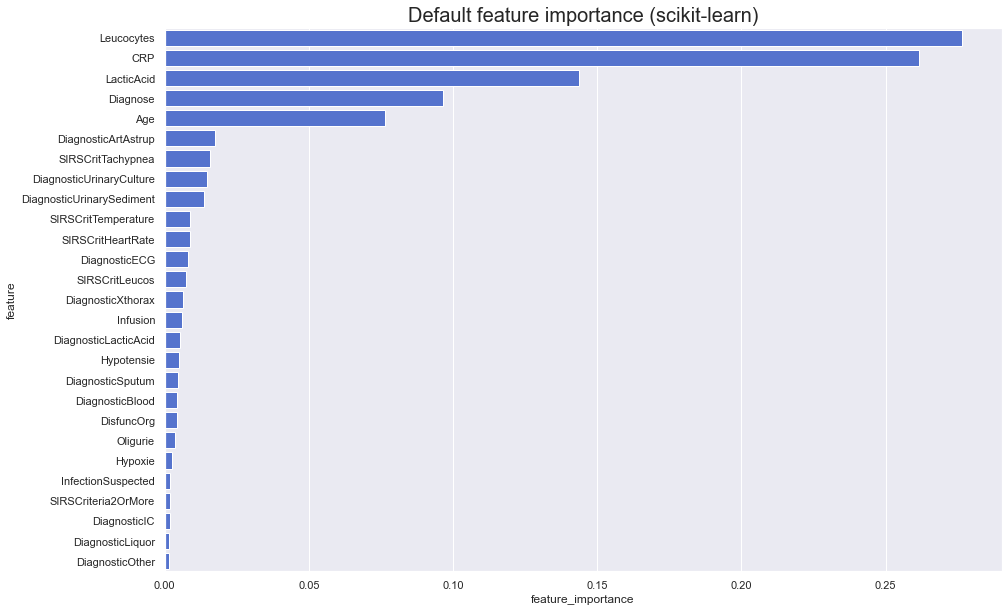

In [136]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

when training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease from each feature can be averaged across trees to determine the final importance of the variable. SelectFromModel will select those features which importance is greater than the *mean importance* of all the features by default

Few of the limitations of Random forest are :
- Correlated features will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts.
- Random Forests and decision trees, in general, give preference to features with high cardinality ( Trees are biased to these type of variables ).

In [137]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
sfm = SelectFromModel(slf)

# Train the selector
sfm.fit(train_features, train_labels)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                                 oob_score=True,
                                                 random_state=42))

In [138]:
# Print the names of the most important features
data_list_important = []
for feature_list_index in sfm.get_support(indices=True):
    print(data_list[feature_list_index])
    data_list_important.append(data_list[feature_list_index])

CRP
LacticAcid
Leucocytes
Diagnose
Age


In [139]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(train_features)
X_important_test = sfm.transform(test_features)

In [140]:
# Create a new random forest classifier for the most important features
slf_important = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
slf_important.fit(X_important_train, train_labels)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)

In [141]:
# Apply The Full Featured Classifier To The Test Data
y_pred = slf.predict(test_features)

# View The Accuracy Of Our Full Feature (4 Features) Model
accuracy_score(test_labels, y_pred)

0.1610148203968852

In [142]:
# Apply The Selected Featured Classifier To The Test Data
y_important_pred = slf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
accuracy_score(test_labels, y_important_pred)

0.1904044209997488

In [143]:
essencial_cols = ['Case ID', 'Activity', 'Complete Timestamp', 'user']

cols = essencial_cols + ['label', 'open_cases'] + data_list_important

In [144]:
cols

['Case ID',
 'Activity',
 'Complete Timestamp',
 'user',
 'label',
 'open_cases',
 'CRP',
 'LacticAcid',
 'Leucocytes',
 'Diagnose',
 'Age']

In [100]:
# first labeling
dt_labeled1 = data.sort_values(timestamp_col, ascending=True, kind="mergesort").groupby(case_id_col).apply(check_if_activity_exists_and_time_less_than, activity="Return ER")
dt_labeled1[cols].to_csv(os.path.join(output_data_folder, "sepsis_cases_1.csv"), sep=",", index=False)

--------------------------
Case ID :  11996    A
11997    A
11998    A
11999    A
12000    A
12001    A
12002    A
12003    A
12004    A
12005    A
12006    A
12007    A
12008    A
12009    A
12010    A
12011    A
12012    A
12013    A
12014    A
12015    A
12016    A
12017    A
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 11996    regular
11997    regular
11998    regular
11999    regular
12000    regular
12001    regular
12002    regular
12003    regular
12004    regular
12005    regular
12006    regular
12007    regular
12008    regular
12009    regular
12010    regular
12011    regular
12012    regular
12013    regular
12014    regular
12015    regular
12016    regular
12017    regular
Name: label, dtype: object
--------------------------
Case ID :  13121    AAA
13122    AAA
13123    AAA
13124    AAA
13125    AAA
13126    AAA
13127    AAA
13128    AAA
13129    AAA
13130    AAA
13131    AAA
Name: Case ID, dtype: obje

--------------------------
Case ID :  5547    BL
5548    BL
5549    BL
5550    BL
5551    BL
5552    BL
5553    BL
5554    BL
5555    BL
5556    BL
5557    BL
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 5547    regular
5548    regular
5549    regular
5550    regular
5551    regular
5552    regular
5553    regular
5554    regular
5555    regular
5556    regular
5557    regular
Name: label, dtype: object
--------------------------
Case ID :  7636    BLA
7637    BLA
7638    BLA
7639    BLA
7640    BLA
7641    BLA
7642    BLA
7643    BLA
7644    BLA
7645    BLA
7646    BLA
7647    BLA
7648    BLA
7649    BLA
7650    BLA
7651    BLA
7652    BLA
7653    BLA
7654    BLA
7655    BLA
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [19] Length : 1
Index : 19
Time :  57710.6 ---decide--- 40320
Label : 7636    regular
7637    regular
7638    regular
7639    regular
7640    regular
7641    regular
7642    

Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [10] Length : 1
Index : 10
Time :  11732.833333333334 ---decide--- 40320
Label : 14182    deviant
14183    deviant
14184    deviant
14185    deviant
14186    deviant
14187    deviant
14188    deviant
14189    deviant
14190    deviant
14191    deviant
14192    deviant
Name: label, dtype: object
--------------------------
Case ID :  4787    CV
4788    CV
4789    CV
4790    CV
4791    CV
4792    CV
4793    CV
4794    CV
4795    CV
4796    CV
4797    CV
4798    CV
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 4787    regular
4788    regular
4789    regular
4790    regular
4791    regular
4792    regular
4793    regular
4794    regular
4795    regular
4796    regular
4797    regular
4798    regular
Name: label, dtype: object
--------------------------
Case ID :  14407    CW
14408    CW
14409    CW
14410    CW
14411    CW
14412    CW
14413    CW
14414   

--------------------------
Case ID :  8319    EE
8320    EE
8321    EE
8322    EE
8323    EE
8324    EE
8325    EE
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 8319    regular
8320    regular
8321    regular
8322    regular
8323    regular
8324    regular
8325    regular
Name: label, dtype: object
--------------------------
Case ID :  2074    EEA
2075    EEA
2076    EEA
2077    EEA
2078    EEA
2079    EEA
2080    EEA
2081    EEA
2082    EEA
2083    EEA
2084    EEA
2085    EEA
2086    EEA
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [12] Length : 1
Index : 12
Time :  201819.56666666668 ---decide--- 40320
Label : 2074    regular
2075    regular
2076    regular
2077    regular
2078    regular
2079    regular
2080    regular
2081    regular
2082    regular
2083    regular
2084    regular
2085    regular
2086    regular
Name: label, dtype: object
--------------------------
Case ID :  5341    EF
5

Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 5668    regular
5669    regular
5670    regular
5671    regular
5672    regular
5673    regular
5674    regular
5675    regular
5676    regular
5677    regular
5678    regular
5679    regular
5680    regular
5681    regular
5682    regular
5683    regular
5684    regular
5685    regular
5686    regular
5687    regular
5688    regular
5689    regular
5690    regular
5691    regular
5692    regular
5693    regular
5694    regular
5695    regular
5696    regular
5697    regular
5698    regular
5699    regular
5700    regular
5701    regular
5702    regular
5703    regular
5704    regular
Name: label, dtype: object
--------------------------
Case ID :  7538    FU
7539    FU
7540    FU
7541    FU
7542    FU
7543    FU
7544    FU
7545    FU
7546    FU
7547    FU
7548    FU
7549    FU
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 7538    regular


Index : 14
Time :  600855.3 ---decide--- 40320
Label : 762    regular
763    regular
764    regular
765    regular
766    regular
767    regular
768    regular
769    regular
770    regular
771    regular
772    regular
773    regular
774    regular
775    regular
776    regular
Name: label, dtype: object
--------------------------
Case ID :  13468    HGA
13469    HGA
13470    HGA
13471    HGA
13472    HGA
13473    HGA
13474    HGA
13475    HGA
13476    HGA
13477    HGA
13478    HGA
13479    HGA
13480    HGA
13481    HGA
13482    HGA
13483    HGA
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 13468    regular
13469    regular
13470    regular
13471    regular
13472    regular
13473    regular
13474    regular
13475    regular
13476    regular
13477    regular
13478    regular
13479    regular
13480    regular
13481    regular
13482    regular
13483    regular
Name: label, dtype: object
--------------------------
Case ID :

--------------------------
Case ID :  2687    IW
2688    IW
2689    IW
2690    IW
2691    IW
2692    IW
2693    IW
2694    IW
2695    IW
2696    IW
2697    IW
2698    IW
2699    IW
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 2687    regular
2688    regular
2689    regular
2690    regular
2691    regular
2692    regular
2693    regular
2694    regular
2695    regular
2696    regular
2697    regular
2698    regular
2699    regular
Name: label, dtype: object
--------------------------
Case ID :  5425    IY
5426    IY
5427    IY
5428    IY
5429    IY
5430    IY
5431    IY
5432    IY
5433    IY
5434    IY
5435    IY
5436    IY
5437    IY
5438    IY
5439    IY
5440    IY
5441    IY
5442    IY
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [17] Length : 1
Index : 17
Time :  41141.1 ---decide--- 40320
Label : 5425    regular
5426    regular
5427    regular
5428    regular
5429    regular
5430    regu

Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 6107    regular
6108    regular
6109    regular
6110    regular
6111    regular
6112    regular
6113    regular
6114    regular
6115    regular
6116    regular
6117    regular
6118    regular
6119    regular
6120    regular
6121    regular
6122    regular
Name: label, dtype: object
--------------------------
Case ID :  6707    KH
6708    KH
6709    KH
6710    KH
6711    KH
6712    KH
6713    KH
6714    KH
6715    KH
6716    KH
6717    KH
6718    KH
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 6707    regular
6708    regular
6709    regular
6710    regular
6711    regular
6712    regular
6713    regular
6714    regular
6715    regular
6716    regular
6717    regular
6718    regular
Name: label, dtype: object
--------------------------
Case ID :  10507    KHA
10508    KHA
10509    KHA
10510    KHA
10511    KHA
1

Name: label, dtype: object
--------------------------
Case ID :  4246    LT
4247    LT
4248    LT
4249    LT
4250    LT
4251    LT
4252    LT
4253    LT
4254    LT
4255    LT
4256    LT
4257    LT
4258    LT
4259    LT
4260    LT
4261    LT
4262    LT
4263    LT
4264    LT
4265    LT
4266    LT
4267    LT
4268    LT
4269    LT
4270    LT
4271    LT
4272    LT
4273    LT
4274    LT
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 4246    regular
4247    regular
4248    regular
4249    regular
4250    regular
4251    regular
4252    regular
4253    regular
4254    regular
4255    regular
4256    regular
4257    regular
4258    regular
4259    regular
4260    regular
4261    regular
4262    regular
4263    regular
4264    regular
4265    regular
4266    regular
4267    regular
4268    regular
4269    regular
4270    regular
4271    regular
4272    regular
4273    regular
4274    regular
Name: label, dtype: object
-------------

--------------------------
Case ID :  3177    NJ
3178    NJ
3179    NJ
3180    NJ
3181    NJ
3182    NJ
3183    NJ
3184    NJ
3185    NJ
3186    NJ
3187    NJ
3188    NJ
3189    NJ
3190    NJ
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [13] Length : 1
Index : 13
Time :  133546.68333333332 ---decide--- 40320
Label : 3177    regular
3178    regular
3179    regular
3180    regular
3181    regular
3182    regular
3183    regular
3184    regular
3185    regular
3186    regular
3187    regular
3188    regular
3189    regular
3190    regular
Name: label, dtype: object
--------------------------
Case ID :  6244    NJA
6245    NJA
6246    NJA
6247    NJA
6248    NJA
6249    NJA
6250    NJA
6251    NJA
6252    NJA
6253    NJA
6254    NJA
6255    NJA
6256    NJA
6257    NJA
6258    NJA
6259    NJA
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 6244    regular
6245    regular
6246    regular
6247    regu

Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 10910    regular
10911    regular
10912    regular
10913    regular
10914    regular
10915    regular
10916    regular
10917    regular
10918    regular
10919    regular
10920    regular
10921    regular
10922    regular
10923    regular
10924    regular
10925    regular
Name: label, dtype: object
--------------------------
Case ID :  8012    PEA
8013    PEA
8014    PEA
8015    PEA
8016    PEA
8017    PEA
8018    PEA
8019    PEA
8020    PEA
8021    PEA
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 8012    regular
8013    regular
8014    regular
8015    regular
8016    regular
8017    regular
8018    regular
8019    regular
8020    regular
8021    regular
Name: label, dtype: object
--------------------------
Case ID :  11180    PF
11181    PF
11182    PF
11183    PF
11184    PF
11185    PF
11186    PF
11187    PF
11188    PF
11189    PF
111

Activity doesn't exit : 9938    regular
9939    regular
9940    regular
9941    regular
9942    regular
9943    regular
9944    regular
9945    regular
9946    regular
9947    regular
9948    regular
9949    regular
9950    regular
9951    regular
9952    regular
9953    regular
9954    regular
9955    regular
9956    regular
9957    regular
9958    regular
9959    regular
9960    regular
9961    regular
9962    regular
9963    regular
9964    regular
9965    regular
9966    regular
Name: label, dtype: object
--------------------------
Case ID :  10360    QY
10361    QY
10362    QY
10363    QY
10364    QY
10365    QY
10366    QY
10367    QY
10368    QY
10369    QY
10370    QY
10371    QY
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 10360    regular
10361    regular
10362    regular
10363    regular
10364    regular
10365    regular
10366    regular
10367    regular
10368    regular
10369    regular
10370    regular
1037

--------------------------
Case ID :  12714    SLA
12715    SLA
12716    SLA
12717    SLA
12718    SLA
12719    SLA
12720    SLA
12721    SLA
12722    SLA
12723    SLA
12724    SLA
12725    SLA
12726    SLA
12727    SLA
12728    SLA
12729    SLA
12730    SLA
12731    SLA
12732    SLA
12733    SLA
12734    SLA
12735    SLA
12736    SLA
12737    SLA
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 12714    regular
12715    regular
12716    regular
12717    regular
12718    regular
12719    regular
12720    regular
12721    regular
12722    regular
12723    regular
12724    regular
12725    regular
12726    regular
12727    regular
12728    regular
12729    regular
12730    regular
12731    regular
12732    regular
12733    regular
12734    regular
12735    regular
12736    regular
12737    regular
Name: label, dtype: object
--------------------------
Case ID :  937    SM
938    SM
939    SM
940    SM
941    SM
942    SM
943  

Activity doesn't exit : 3672    regular
3673    regular
3674    regular
3675    regular
3676    regular
3677    regular
3678    regular
3679    regular
3680    regular
3681    regular
3682    regular
Name: label, dtype: object
--------------------------
Case ID :  5634    UBA
5635    UBA
5636    UBA
5637    UBA
5638    UBA
5639    UBA
5640    UBA
5641    UBA
5642    UBA
5643    UBA
5644    UBA
5645    UBA
5646    UBA
5647    UBA
5648    UBA
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [14] Length : 1
Index : 14
Time :  535694.9166666666 ---decide--- 40320
Label : 5634    regular
5635    regular
5636    regular
5637    regular
5638    regular
5639    regular
5640    regular
5641    regular
5642    regular
5643    regular
5644    regular
5645    regular
5646    regular
5647    regular
5648    regular
Name: label, dtype: object
--------------------------
Case ID :  2632    UC
2633    UC
2634    UC
2635    UC
2636    UC
2637    UC
2638    UC
2639    UC
2640    

Label : 10260    regular
10261    regular
10262    regular
10263    regular
10264    regular
10265    regular
10266    regular
10267    regular
10268    regular
10269    regular
10270    regular
10271    regular
10272    regular
10273    regular
Name: label, dtype: object
--------------------------
Case ID :  10523    VY
10524    VY
10525    VY
10526    VY
10527    VY
10528    VY
10529    VY
10530    VY
10531    VY
10532    VY
10533    VY
10534    VY
10535    VY
10536    VY
10537    VY
10538    VY
10539    VY
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 10523    regular
10524    regular
10525    regular
10526    regular
10527    regular
10528    regular
10529    regular
10530    regular
10531    regular
10532    regular
10533    regular
10534    regular
10535    regular
10536    regular
10537    regular
10538    regular
10539    regular
Name: label, dtype: object
--------------------------
Case ID :  12921    W
12922   

Label : 0     deviant
1     deviant
2     deviant
3     deviant
4     deviant
5     deviant
6     deviant
7     deviant
8     deviant
9     deviant
10    deviant
11    deviant
12    deviant
Name: label, dtype: object
--------------------------
Case ID :  1035    XJA
1036    XJA
1037    XJA
1038    XJA
1039    XJA
1040    XJA
1041    XJA
1042    XJA
1043    XJA
1044    XJA
1045    XJA
1046    XJA
1047    XJA
1048    XJA
1049    XJA
1050    XJA
1051    XJA
1052    XJA
1053    XJA
1054    XJA
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 1035    regular
1036    regular
1037    regular
1038    regular
1039    regular
1040    regular
1041    regular
1042    regular
1043    regular
1044    regular
1045    regular
1046    regular
1047    regular
1048    regular
1049    regular
1050    regular
1051    regular
1052    regular
1053    regular
1054    regular
Name: label, dtype: object
--------------------------
Case ID :  6260    

Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [9] Length : 1
Index : 9
Time :  33654.98333333333 ---decide--- 40320
Label : 10175    deviant
10176    deviant
10177    deviant
10178    deviant
10179    deviant
10180    deviant
10181    deviant
10182    deviant
10183    deviant
10184    deviant
Name: label, dtype: object
--------------------------
Case ID :  6349    YO
6350    YO
6351    YO
6352    YO
6353    YO
6354    YO
6355    YO
6356    YO
6357    YO
6358    YO
6359    YO
6360    YO
6361    YO
6362    YO
6363    YO
6364    YO
6365    YO
6366    YO
6367    YO
6368    YO
6369    YO
6370    YO
6371    YO
6372    YO
6373    YO
6374    YO
6375    YO
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 6349    regular
6350    regular
6351    regular
6352    regular
6353    regular
6354    regular
6355    regular
6356    regular
6357    regular
6358    regular
6359    regular
6360    regular
6361    regu

Case ID :  13371    ZV
13372    ZV
13373    ZV
13374    ZV
13375    ZV
13376    ZV
13377    ZV
13378    ZV
13379    ZV
13380    ZV
13381    ZV
13382    ZV
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 13371    regular
13372    regular
13373    regular
13374    regular
13375    regular
13376    regular
13377    regular
13378    regular
13379    regular
13380    regular
13381    regular
13382    regular
Name: label, dtype: object
--------------------------
Case ID :  11125    ZW
11126    ZW
11127    ZW
11128    ZW
11129    ZW
11130    ZW
11131    ZW
11132    ZW
11133    ZW
11134    ZW
11135    ZW
11136    ZW
11137    ZW
Name: Case ID, dtype: object
Activity : Return ER
Relevent Activity Idx : [] Length : 0
Activity doesn't exit : 11125    regular
11126    regular
11127    regular
11128    regular
11129    regular
11130    regular
11131    regular
11132    regular
11133    regular
11134    regular
11135    regular
11136    

In [87]:
# second labeling
dt_labeled2 = data.sort_values(timestamp_col, ascending=True, kind="mergesort").groupby(case_id_col).apply(check_if_activity_exists, activity="Admission IC")
dt_labeled2[cols].to_csv(os.path.join(output_data_folder, "sepsis_cases_2.csv"), sep=",", index=False)

In [88]:
# fourth labeling
dt_labeled3 = data.sort_values(timestamp_col, ascending=True, kind="mergesort").groupby(case_id_col).apply(check_if_activity_exists, activity="Release A")
dt_labeled3[cols].to_csv(os.path.join(output_data_folder, "sepsis_cases_4.csv"), sep=",", index=False)

In [146]:
data[essencial_cols + ['open_cases'] + data_list_important].to_csv(os.path.join(output_data_folder, "sepsis_cases.csv"), sep=",", index=False)

Rest of the feature selection is based on the Mean Decrease Impurity and Mean Decrease Accuracy, usig the article :

https://blog.datadive.net/selecting-good-features-part-iii-random-forests/

https://stats.stackexchange.com/questions/191686/random-forests-for-optimal-variable-selection-feature-selection

https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

#### Drop Column feature importance

In [90]:
from sklearn.base import clone 

def drop_col_feat_imp(model, train_features, train_labels, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(train_features, train_labels)
    benchmark_score = model_clone.score(train_features, train_labels)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in train_features.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(train_features.drop(col, axis = 1), train_labels)
        drop_col_score = model_clone.score(train_features.drop(col, axis = 1), train_labels)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(train_features.columns, importances)
    return importances_df

In [ ]:
drop_imp = drop_col_feat_imp(slf, train_features, train_labels)

In [ ]:
var_imp_plot(drop_imp, 'Drop Column feature importance')

#### Permutation Based Feature Importance

This method will randomly shuffle each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important one. The permutation based method can have problem with highly-correlated features, it can report them as unimportant.

https://mljar.com/blog/feature-importance-in-random-forest/

In [136]:
perm_importance = permutation_importance(slf, train_features, train_labels)

In [137]:
sorted_idx = perm_importance.importances_mean.argsort()

<BarContainer object of 27 artists>

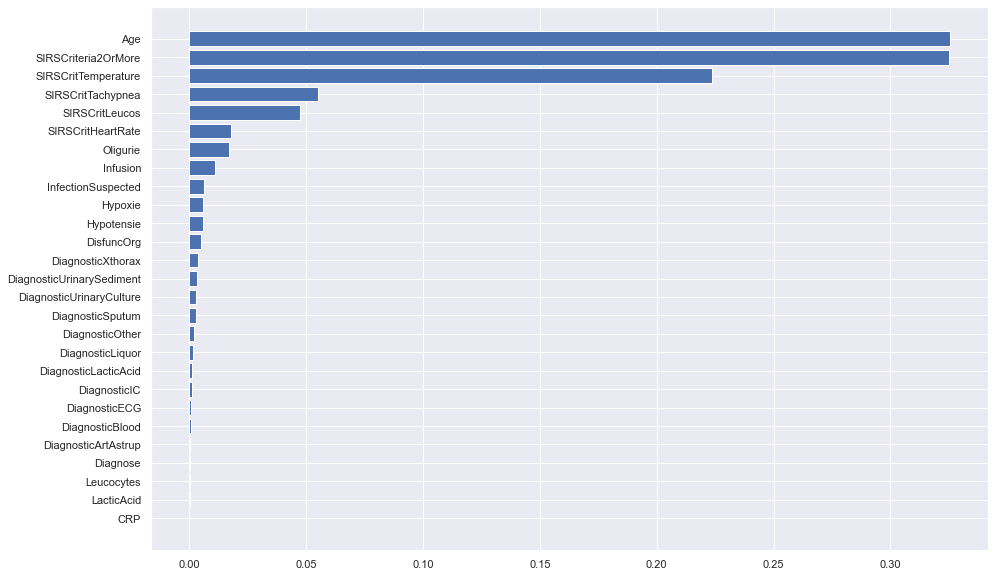

In [139]:
#perm_imp = imp_df(train_features.columns, perm_importance.feature_importances_)
plt.barh(train_features.columns, perm_importance.importances_mean[sorted_idx])

In [141]:
#var_imp_plot(perm_imp, 'Default feature importance (scikit-learn)')

#### Feature Importance Computed with SHAP Values

It is using the Shapley values from game theory to estimate the how does each feature contribute to the prediction and it is model-agnostic

In [ ]:
#-- Commented because it takes lot of time

# explainer = shap.TreeExplainer(slf)
# shap_values = explainer.shap_values(train_features)

In [ ]:
# shap.summary_plot(shap_values, X_test, plot_type="bar")